In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/Shareddrives/BioMed+CV: Dental Project/CRF_Check/continuity metrices"

/content/drive/Shareddrives/BioMed+CV: Dental Project/CRF_Check/continuity metrices


In [3]:
%cd M2U-Net
!pip install torch torchvision pillow numpy

/content/drive/Shareddrives/BioMed+CV: Dental Project/CRF_Check/continuity metrices/M2U-Net


In [ ]:
from torch.utils.data import random_split, DataLoader
from dataset import RetinaDataset, get_file_lists
from pathlib import Path

# === TRAINING SETUP ===
train_image_dir = Path('data/DRIVE/training/images/')
train_file_paths = get_file_lists(train_image_dir)

# Create full dataset (includes image, label, mask)
full_dataset = RetinaDataset(train_file_paths, dataset='DRIVE')

# Split 85% train / 15% validation
val_size = int(0.15 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

# === TEST SETUP ===
test_image_dir = Path('data/DRIVE/test/images/')
test_file_paths = get_file_lists(test_image_dir)
test_dataset = RetinaDataset(test_file_paths, dataset='DRIVE')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

KeyboardInterrupt: 

In [ ]:
import torch
from erfnet import Net
from dataset import RetinaDataset, get_file_lists
from pathlib import Path
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Model
model = Net(num_classes=1).to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
bce_loss = nn.BCEWithLogitsLoss()

# Jaccard index (soft version for logits)
def jaccard_index(pred, target, smooth=1e-8):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    j = (intersection + smooth) / (union + smooth)
    return j.mean()

In [ ]:
# Training loop
num_epochs = 300
best_val_dice = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        masks  = batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Combined loss
        loss_bce = bce_loss(outputs, labels)
        jaccard = jaccard_index(outputs, labels)
        loss = loss_bce + 0.3 * (1 - jaccard)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    model.eval()
    dice_list = []

    with torch.no_grad():
      for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        masks  = batch['mask'].to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        # Dice only in valid FOV
        intersection = ((preds * labels) * masks).sum()
        union = ((preds + labels) * masks).sum()
        dice = (2.0 * intersection + 1e-8) / (union + 1e-8)
        dice_list.append(dice.item())

    val_dice = sum(dice_list) / len(dice_list)
    print(f"Validation Dice: {val_dice:.4f}")

    # Save best model
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'erfnet_drive_best.pth')
        print("Model saved!")

print("Training complete.")


In [ ]:
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as VF
from pathlib import Path
from PIL import Image
import numpy as np
import time
from dataset import RetinaDataset, get_file_lists
from erfnet import Net  # Make sure the model definition matches your training

def test_model(model, dataloader, device, threshold=0.5,
               save_dir="data/DRIVE/predictions", save_prob=True, save_binary=True):
    """
    Evaluate the model on test set and save probability & binary outputs.
    """
    model.eval()
    model.to(device)
    sigmoid = torch.nn.Sigmoid()

    save_dir = Path(save_dir)
    if save_prob:
        (save_dir / "erfprobability").mkdir(parents=True, exist_ok=True)
    if save_binary:
        (save_dir / "erfbinary").mkdir(parents=True, exist_ok=True)

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            img = batch['image'].to(device)  # [B, C, H, W]
            base_names = batch.get("file_name", [f"img_{idx}"])  # Fallback if missing

            start_time = time.perf_counter()
            output = model(img)  # Raw logits
            prob = sigmoid(output)
            pred_bin = (prob > threshold).float()
            elapsed = (time.perf_counter() - start_time) / img.size(0)

            print(f"Batch {idx + 1}/{len(dataloader)} - Inference time per image: {elapsed:.4f}s")

            for b in range(img.size(0)):
                name = base_names[b] if isinstance(base_names[b], str) else f"img_{idx}_{b}"
                if save_prob:
                    prob_img = VF.to_pil_image(prob[b].cpu())
                    prob_img.save(save_dir / "erfprobability" / f"{name}_prob.gif")
                if save_binary:
                    binary_img = VF.to_pil_image(pred_bin[b].cpu())
                    binary_img.save(save_dir / "erfbinary" / f"{name}_binary.gif")


In [ ]:
# === Load Trained Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_classes=1).to(device)
model.load_state_dict(torch.load("erfnet_drive_best.pth", map_location=device))

# === Run Test ===
test_model(model, test_loader, device, threshold=0.5, save_dir='data/DRIVE/predictions', save_prob=True, save_binary=True)

Batch 1/20 - Inference time per image: 0.3883s


KeyboardInterrupt: 

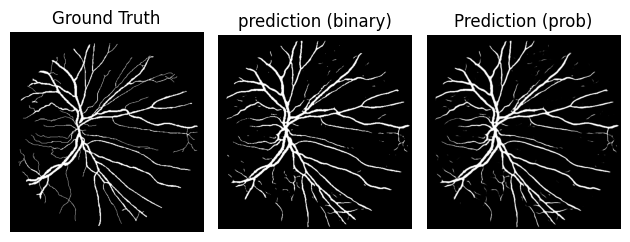

In [ ]:
import matplotlib.pyplot as plt
import torch

image = 15

gt_path = f'data/DRIVE/test/1st_manual/{image:02d}_manual1.gif'
gt = Image.open(gt_path).convert('L')
gt_array = np.array(gt)

b_path = f'data/DRIVE/predictions/erfbinary/img_{image-1}_binary.gif'
b = Image.open(b_path).convert('L')
b_array = np.array(b)

p_path = f'data/DRIVE/predictions/erfprobability/img_{image-1}_prob.gif'
p = Image.open(p_path).convert('L')
p_array = np.array(p)

plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(gt_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('prediction (binary)')
plt.imshow(b_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Prediction (prob)')
plt.imshow(p_array, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skimage.morphology import skeletonize
from torchvision.transforms.functional import center_crop

# ---------- clDice Function ----------
def cldice(gt, pred):
    S_gt = skeletonize(gt)
    S_pred = skeletonize(pred)
    tprec = np.sum(S_pred * gt) / (np.sum(S_pred) + 1e-8)
    tsens = np.sum(S_gt * pred) / (np.sum(S_gt) + 1e-8)
    return (2 * tprec * tsens) / (tprec + tsens + 1e-8)

# ---------- Dice Function ----------
def dice_score(gt, pred):
    intersection = np.sum(gt * pred)
    return (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)

# ---------- Initialize accumulators ----------
gt_all = []
pred_all = []

dice_list = []
cldice_list = []

# ---------- Loop over all 20 test cases ----------
for i in range(1, 21):
    case_id = f"{i:02d}"

    # Load ground truth
    gt_path = f"data/DRIVE/test/1st_manual/{case_id}_manual1.gif"
    gt = Image.open(gt_path).convert("L")
    gt = center_crop(gt, (544, 544))
    gt = np.array(gt)
    gt = (gt > 127).astype(np.uint8)  # binarize

    # Load prediction
    pred_path = f"data/DRIVE/predictions/erfbinary/img_{i-1}_binary.gif"
    pred = np.array(Image.open(pred_path).convert("L"))
    pred = (pred > 127).astype(np.uint8)  # binarize

    # Flatten for sklearn metrics
    gt_all.extend(gt.flatten())
    pred_all.extend(pred.flatten())

    # Dice and clDice per image
    dice_list.append(dice_score(gt, pred))
    cldice_list.append(cldice(gt, pred))

# ---------- Compute Overall Metrics ----------
gt_all = np.array(gt_all)
pred_all = np.array(pred_all)

accuracy = accuracy_score(gt_all, pred_all)
precision = precision_score(gt_all, pred_all)
recall = recall_score(gt_all, pred_all)
dice = np.mean(dice_list)
cl_dice = np.mean(cldice_list)

# ---------- Print Results ----------
print(f"Overall Accuracy : {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall   : {recall:.4f}")
print(f"Mean Dice        : {dice:.4f}")
print(f"Mean clDice      : {cl_dice:.4f}")


Overall Accuracy : 0.9572
Overall Precision: 0.7918
Overall Recall   : 0.7615
Mean Dice        : 0.7757
Mean clDice      : 0.7570


#Pretrained Model

In [ ]:
!python benchmark_pytorch.py \
  --model ERFNet \
  --state_dict models/ERFNetDRIVE.pth \
  --dataset DRIVE \
  --threshold 0.5 \
  --devicename cpu \
  --batch_size 1 \
  --save_prob 1 \
  --save_binary_mask 1

Batch 1/20 inference time per image: 0.94473s
Batch 2/20 inference time per image: 0.62003s
Batch 3/20 inference time per image: 0.55377s
Batch 4/20 inference time per image: 0.60446s
Batch 5/20 inference time per image: 0.55088s
Batch 6/20 inference time per image: 0.73352s
Batch 7/20 inference time per image: 0.78417s
Batch 8/20 inference time per image: 0.82317s
Batch 9/20 inference time per image: 0.85972s
Batch 10/20 inference time per image: 0.53030s
Batch 11/20 inference time per image: 0.60427s
Batch 12/20 inference time per image: 0.55999s
Batch 13/20 inference time per image: 0.61533s
Batch 14/20 inference time per image: 0.59167s
Batch 15/20 inference time per image: 0.57688s
Batch 16/20 inference time per image: 0.80806s
Batch 17/20 inference time per image: 0.73219s
Batch 18/20 inference time per image: 0.65746s
Batch 19/20 inference time per image: 0.54015s
Batch 20/20 inference time per image: 0.57972s

Mean inference time per image: 0.64872s


In [4]:
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skimage.morphology import skeletonize
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from skimage.measure import label

# ---------- clDice Function ----------
def cldice(gt, pred):
    S_gt = skeletonize(gt)
    S_pred = skeletonize(pred)
    tprec = np.sum(S_pred * gt) / (np.sum(S_pred) + 1e-8)
    tsens = np.sum(S_gt * pred) / (np.sum(S_gt) + 1e-8)
    return (2 * tprec * tsens) / (tprec + tsens + 1e-8)

# ---------- IoU Function ----------
def iou_score(gt, pred):
    intersection = np.sum(gt * pred)
    union = np.sum(gt) + np.sum(pred) - intersection
    return intersection / (union + 1e-8)

# ---------- Dice Function ----------
def dice_score(gt, pred):
    intersection = np.sum(gt * pred)
    return (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)

# --- Betti numbers computation function ---
def betti_numbers(mask):
    mask = mask.astype(bool)
    b0 = label(mask, connectivity=1).max()  # number of connected components
    filled = binary_fill_holes(mask)        # fill holes
    holes = filled ^ mask                   # holes = filled - original
    b1 = label(holes, connectivity=1).max() # number of holes
    return b0, b1

def chamfer_distance(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)

    dist1 = distance_transform_edt(~mask1)
    dist2 = distance_transform_edt(~mask2)

    chamfer1 = dist2[mask1].mean()
    chamfer2 = dist1[mask2].mean()

    return (chamfer1 + chamfer2) / 2.0


# ---------- Initialize accumulators ----------
gt_all = []
pred_all = []

dice_list = []
cldice_list = []
chamfer_list = []
iou_list = []

# ---------- Loop over all 20 test cases ----------
for i in range(1, 21):
    # Load ground truth
    gt_path = f'data/DRIVE/testt/{i:02d}_manual1.npy'
    gt = np.load(gt_path)

    # Load prediction
    binary_img = Image.open(f'data/DRIVE/predictions/ERFNet_pretrain/{i:02d}_test_vessel_binary.gif').convert('L')
    binary_array = np.array(binary_img)
    pred_array = (binary_array > 127).astype(np.uint8)

    # Flatten for sklearn metrics
    gt_all.extend(gt.flatten())
    pred_all.extend(pred_array.flatten())

    # Dice and clDice per image
    dice_list.append(dice_score(gt, pred_array))
    cldice_list.append(cldice(gt, pred_array))
    chamfer_list.append(chamfer_distance(gt, pred_array))
    iou_list.append(iou_score(gt, pred_array))

# ---------- Compute Overall Metrics ----------
gt_all = np.array(gt_all)
pred_all = np.array(pred_all)

accuracy = accuracy_score(gt_all, pred_all)
precision = precision_score(gt_all, pred_all)
recall = recall_score(gt_all, pred_all)
dice = np.mean(dice_list)
cl_dice = np.mean(cldice_list)
chamfer_mean = np.mean(chamfer_list)
iou_mean = np.mean(iou_list)

# Compute Betti numbers
b0_gt, b1_gt = betti_numbers(gt_all)
b0_pred, b1_pred = betti_numbers(pred_all)

# ---------- Print Results ----------
print(f"Overall Accuracy : {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall   : {recall:.4f}")
print(f"Mean Dice        : {dice:.4f}")
print(f"Mean IoU         : {iou_mean:.4f}")
print(f"Mean clDice      : {cl_dice:.4f}")
print(f"Mean ChamferDist : {chamfer_mean:.4f}")
print(f"Ground Truth - B0: {b0_gt}, B1: {b1_gt}")
print(f"Prediction   - B0: {b0_pred}, B1: {b1_pred}")


Overall Accuracy : 0.9602
Overall Precision: 0.8870
Overall Recall   : 0.6789
Mean Dice        : 0.7694
Mean IoU         : 0.6257
Mean clDice      : 0.7574
Mean ChamferDist : 0.8150
Ground Truth - B0: 114144, B1: 114143
Prediction   - B0: 80250, B1: 80249


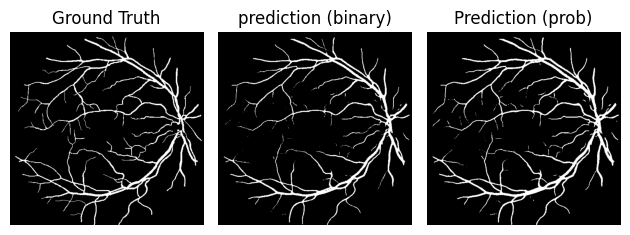

Accuracy:  0.9672
Precision: 0.8324
Recall:    0.7519
Dice:      0.7901
clDice:    0.8084
Chamfer Dist:    0.5291
Betti-0 (connected components): 270
Betti-1 (holes): 30
GT-Betti-0 (connected components): 136
GT-Betti-1 (holes): 35


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from torchvision.transforms.functional import center_crop

from skimage.measure import label
from scipy.ndimage import binary_fill_holes, distance_transform_edt
import scipy.ndimage as ndi

image = 20

gt_path = f'data/DRIVE/testt/{image:02d}_manual1.gif'
gt = Image.open(gt_path).convert('L')
gt = center_crop(gt, (544, 544))
gt_array = np.array(gt)

b_path = f'data/DRIVE/predictions/ERFNet_pretrain/{image:02d}_test_vessel_binary.gif'
b = Image.open(b_path).convert('L')
b_array = np.array(b)

p_path = f'data/DRIVE/predictions/ERFNet_pretrain/{image:02d}_test_vessel_prob.gif'
p = Image.open(p_path).convert('L')
p_array = np.array(p)/ 255.0
p_array = (p_array > 0.25).astype(np.uint8)

plt.subplot(1, 3, 1)
plt.title('Ground Truth')
plt.imshow(gt_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('prediction (binary)')
plt.imshow(b_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Prediction (prob)')
plt.imshow(p_array, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

from skimage.morphology import skeletonize

def compute_skeleton(mask):
    return skeletonize(mask > 0)

def cl_dice(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)

    pred_skel = compute_skeleton(pred)
    gt_skel = compute_skeleton(gt)

    # Intersection over skeletons
    tprec = (pred[gt_skel]).sum() / (gt_skel.sum() + 1e-8)
    tsens = (gt[pred_skel]).sum() / (pred_skel.sum() + 1e-8)

    return 2 * tprec * tsens / (tprec + tsens + 1e-8)

def betti_numbers(mask):
    """
    Compute Betti numbers for a 2D binary mask.
    """
    # Ensure binary mask
    mask = mask.astype(bool)
    # B0 = number of connected components
    b0 = label(mask, connectivity=1).max()
    # Fill holes to get b1
    filled = binary_fill_holes(mask)
    holes = filled ^ mask  # XOR gives holes
    # B1 = number of holes (connected components in holes)
    b1 = label(holes, connectivity=1).max()

    return b0, b1

def chamfer_distance(mask1, mask2):
    """
    Compute symmetric Chamfer Distance between two binary masks.
    """
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)

    # Compute distance maps
    dist1 = distance_transform_edt(~mask1)
    dist2 = distance_transform_edt(~mask2)

    # Chamfer from mask1 to mask2
    chamfer1 = dist2[mask1].mean()
    chamfer2 = dist1[mask2].mean()

    return (chamfer1 + chamfer2) / 2.0

# Load ground truth
gt_path = f"data/DRIVE/testt/{image:02d}_manual1.gif"
gt = Image.open(gt_path).convert("L")
gt = center_crop(gt, (544, 544))
gt = np.array(gt)
gt = (gt > 127).astype(np.uint8)  # binarize

# Load prediction
pred_path = f"data/DRIVE/predictions/ERFNet_pretrain/{image:02d}_test_vessel_binary.gif"
pred = np.array(Image.open(pred_path).convert("L"))
pred = (pred > 127).astype(np.uint8)  # binarize

gt_tensor = torch.from_numpy(gt).long().flatten()
pred_tensor = torch.from_numpy(pred).long().flatten()

acc = accuracy_score(gt_tensor, pred_tensor)
prec = precision_score(gt_tensor, pred_tensor, zero_division=0)
rec = recall_score(gt_tensor, pred_tensor, zero_division=0)
dice = f1_score(gt_tensor, pred_tensor, zero_division=0)  # Dice is F1 in binary case
cldice = cl_dice(pred, gt)
chamfer = chamfer_distance(pred, gt)

# Print
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"Dice:      {dice:.4f}")
print(f"clDice:    {cldice:.4f}")
print(f"Chamfer Dist:    {chamfer:.4f}")

b0, b1 = betti_numbers(pred)
gtb0, gtb1 = betti_numbers(gt)
print(f"Betti-0 (connected components): {b0}")
print(f"Betti-1 (holes): {b1}")
print(f"GT-Betti-0 (connected components): {gtb0}")
print(f"GT-Betti-1 (holes): {gtb1}")